In [1]:
from elpv_reader import load_dataset
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from keras import datasets, layers, models
from keras.utils import to_categorical
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [3]:
# load data
images, probs, types = load_dataset()

# Make probs labels
probs = np.array([int(i*3) for i in probs])

In [4]:
# process the images with threshold
IMAGES = []
for i in images:
    _, thresh = cv2.threshold(i, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    IMAGES.append(thresh)
IMAGES = np.array(IMAGES)
images = IMAGES

In [4]:
# Count each unique label's occurrence
# label_counts = {label: probs.count(label) for label in set(probs)}
# print("Total counts per class:", label_counts)

# Reshape images to 2D for SMOTE
num_images, height, width = images.shape
images_reshaped = images.reshape(num_images, -1)

# Apply SMOTE
smote = SMOTE()
X_over, y_labels_over = smote.fit_resample(images_reshaped, probs)

# After oversampling, reshape the images back to the original shape
X_over_reshaped = X_over.reshape(-1, height, width)

# Now you need to construct 'types_over'. This part needs careful attention.
# Since SMOTE creates new samples, we cannot simply repeat the 'types'.
# Here's a simple way to do it: for each new sample in 'y_over' that was not in the original 'y_labels',
# we randomly assign a 'type' from the original 'types' corresponding to the same class.

# Find the indices of the added samples
new_indices = [i for i in range(len(y_labels_over)) if i >= len(probs)]

# Initialize types_over with the original types
types_over = types.tolist()

# Append types for the new, oversampled indices
for i in new_indices:
    # Get the label of the new sample
    label = y_labels_over[i]
    
    # Get the indices of the original samples with the same label
    original_indices = [j for j, l in enumerate(probs) if l == label]
    
    # Randomly choose a type from the original samples of the same label
    chosen_type = types[np.random.choice(original_indices)]
    
    # Append this type to types_over
    types_over.append(chosen_type)

# Ensure that 'types_over' is now a numpy array
types_over = np.array(types_over)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, types_train, types_test = train_test_split(
    X_over_reshaped, y_labels_over, types_over, test_size=0.25, stratify=y_labels_over
)

train_y = to_categorical(y_train, num_classes=4)
test_y = to_categorical(y_test, num_classes=4)

In [5]:
# ratio = 0.7
# th = int(2624*.7)
# train_x = images[:1968]
# train_y = to_categorical(probs[:1968], num_classes=4)

# test_x = images[-656:]
# test_y = to_categorical(probs[-656:], num_classes=4)

In [6]:
# monocrystalline dataset
mono_images = np.array([images[i] for i in range(len(types)) if types[i]=='mono'])
mono_probs = to_categorical(np.array([probs[i] for i in range(len(types)) if types[i]=='mono']), num_classes=4)

# polycrystalline dataset
poly_images = np.array([images[i] for i in range(len(types)) if types[i]=='poly'])
poly_probs = to_categorical(np.array([probs[i] for i in range(len(types)) if types[i]=='poly']), num_classes=4)

In [7]:
model1 = models.Sequential()
model1.add(layers.Conv2D(6, (3, 3), activation='relu', input_shape=(300, 300, 1)))
model1.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
# model.add(layers.Conv2D(10, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

model1.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(4, activation='softmax'))

In [8]:
# vgg19
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(300, 300, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
# model.summary()


In [9]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
    # SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model1.fit(X_train, train_y, epochs=10)

Epoch 1/10
142/142 [==============================] - 17s 116ms/step - loss: 153.4294 - accuracy: 0.6408
Epoch 2/10
142/142 [==============================] - 17s 120ms/step - loss: 2.0636 - accuracy: 0.9264
Epoch 3/10
142/142 [==============================] - 17s 120ms/step - loss: 0.9236 - accuracy: 0.9587
Epoch 4/10
142/142 [==============================] - 17s 117ms/step - loss: 0.6446 - accuracy: 0.9684
Epoch 5/10
142/142 [==============================] - 17s 119ms/step - loss: 0.3602 - accuracy: 0.9825
Epoch 6/10
142/142 [==============================] - 17s 123ms/step - loss: 0.3989 - accuracy: 0.9850
Epoch 7/10
142/142 [==============================] - 18s 125ms/step - loss: 0.8408 - accuracy: 0.9699
Epoch 8/10
142/142 [==============================] - 18s 124ms/step - loss: 0.5083 - accuracy: 0.9819
Epoch 9/10
142/142 [==============================] - 17s 119ms/step - loss: 0.5312 - accuracy: 0.9832
Epoch 10/10
142/142 [==============================] - 17s 120ms/step -

In [10]:
test_loss, test_acc = model1.evaluate(X_test, test_y)

48/48 [==============================] - 2s 30ms/step - loss: 8.8813 - accuracy: 0.8992


In [11]:
def summary(true_y, pred_y, title):
    print(title+':\n')
    print(f'accuracy: {accuracy_score(true_y, pred_y):.2f}\n')
    print(f'f1: {f1_score(true_y, pred_y, average="weighted"):.2f}\n')
    ConfusionMatrixDisplay(confusion_matrix(true_y, pred_y)).plot()

48/48 [==============================] - 2s 30ms/step
mono and poly:

accuracy: 0.90

f1: 0.90

34/34 [==============================] - 1s 30ms/step
mono:

accuracy: 0.95

f1: 0.95

49/49 [==============================] - 1s 30ms/step
poly:

accuracy: 0.94

f1: 0.94



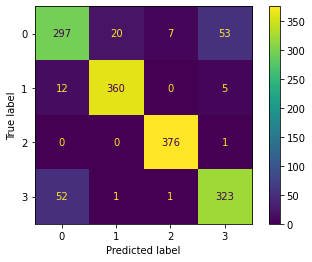

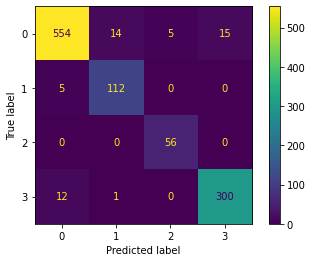

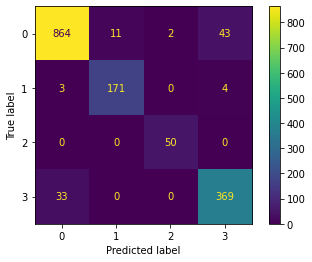

In [12]:
# mono_probs = np.array([probs[i] for i in range(len(types)) if types[i]=='mono'])
summary(np.argmax(test_y, axis=1), np.argmax(model1.predict(X_test), axis=1), 'mono and poly')
summary(np.argmax(mono_probs, axis=1), np.argmax(model1.predict(mono_images), axis=1), 'mono')
summary(np.argmax(poly_probs, axis=1), np.argmax(model1.predict(poly_images), axis=1), 'poly')

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
    # SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, train_y, epochs=10)

Epoch 1/10
142/142 [==============================] - 1689s 12s/step - loss: 25.2742 - accuracy: 0.2465
Epoch 2/10
142/142 [==============================] - 1674s 12s/step - loss: 1.3866 - accuracy: 0.2498
Epoch 3/10
142/142 [==============================] - 1705s 12s/step - loss: 1.4724 - accuracy: 0.2520
Epoch 4/10
142/142 [==============================] - 1732s 12s/step - loss: 1.4027 - accuracy: 0.2471
Epoch 5/10
142/142 [==============================] - 1690s 12s/step - loss: 1.3985 - accuracy: 0.2423
Epoch 6/10
142/142 [==============================] - 1710s 12s/step - loss: 1.3866 - accuracy: 0.2451
Epoch 7/10
142/142 [==============================] - 1728s 12s/step - loss: 1.3865 - accuracy: 0.2458
Epoch 8/10
142/142 [==============================] - 1719s 12s/step - loss: 1.3864 - accuracy: 0.2394
Epoch 9/10
142/142 [==============================] - 1708s 12s/step - loss: 1.3865 - accuracy: 0.2449
Epoch 10/10
142/142 [==============================] - 1699s 12s/step - 

48/48 [==============================] - 111s 2s/step
mono and poly:

accuracy: 0.25

f1: 0.10

34/34 [==============================] - 77s 2s/step
mono:

accuracy: 0.05

f1: 0.01

49/49 [==============================] - 92s 2s/step
poly:

accuracy: 0.03

f1: 0.00



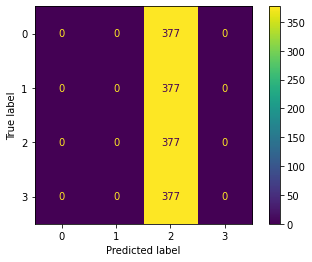

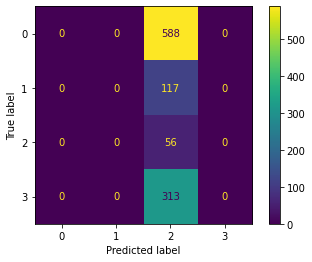

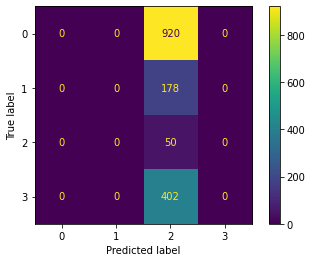

In [14]:
summary(np.argmax(test_y, axis=1), np.argmax(model.predict(X_test), axis=1), 'mono and poly')
summary(np.argmax(mono_probs, axis=1), np.argmax(model.predict(mono_images), axis=1), 'mono')
summary(np.argmax(poly_probs, axis=1), np.argmax(model.predict(poly_images), axis=1), 'poly')